In [99]:
import os
os.chdir('d:/future/Index_Future_Prediction')

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from torch.utils.data import TensorDataset, DataLoader

from utils.random_split import RandomSplit, CallableDataset
from utils.back_test import BackTest
from utils.hybrid_loss import HybridLoss
from utils.hybrid_decoder import HybridDecoder
from utils.prediction_recorder import PredictionRecorder
from utils.train_animator import TrainAnimator
from utils.model_train import ModelTrain
from utils.balance_sampler import BalancedSampler

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [100]:
feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
label_columns = ['label_return','down_prob','middle_prob','up_prob']
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX',]

In [101]:

seq_len = 20
pred_len = 5
train_ratio = 0.5
validation_ratio = 0.2
test_ratio = 0.03

hidden_size = 10
num_layers = 1

In [102]:
feature = []
label = []

for asset_code in assets_list:
    data = pd.read_csv(f'data/{asset_code}.csv')
    feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
    label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

# 加载数据
feature = torch.stack(feature, dim = 1)
label = torch.stack(label, dim = 1)
print(feature.shape, label.shape)

# 折叠时间步
feature = feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(2,3)
label = label[seq_len-1:]
# 归并品种
feature = torch.flatten(feature, start_dim=0, end_dim = 1)
label = torch.flatten(label, start_dim=0, end_dim = 1)

feature.shape, label.shape

torch.Size([2603, 3, 10]) torch.Size([2603, 3, 4])


(torch.Size([7752, 20, 10]), torch.Size([7752, 4]))

In [103]:
recorder = PredictionRecorder()
animator = TrainAnimator(figsize=(12,6))

Animator data has been reset.


In [104]:
class Baseline_LSTM(nn.Module):
    """循环神经网络模型"""
    def __init__(self, input_size, hidden_size, num_layers, dropout, **kwargs):
        super(Baseline_LSTM, self).__init__(**kwargs)
        self.device = 'cuda:0'
        self.process = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            dropout = dropout,
            batch_first = True,
            # nonlinearity='relu',
        )
        self.output = nn.Sequential(
            nn.Dropout(dropout),
            HybridDecoder(dim_state = hidden_size, init_prob = [0.0,0.5,0.0])
        )
        

    def forward(self, x):
        #为了提升模型的泛化能力，我们每次输入都随机舍弃一部分前端的序列
        if self.training:
            seq_len = x.shape[1]
            random_drop = np.random.randint(0, seq_len//2)
            x = x[:,random_drop:,:] 

        return self.output(self.process(x)[0][:,-1,:])

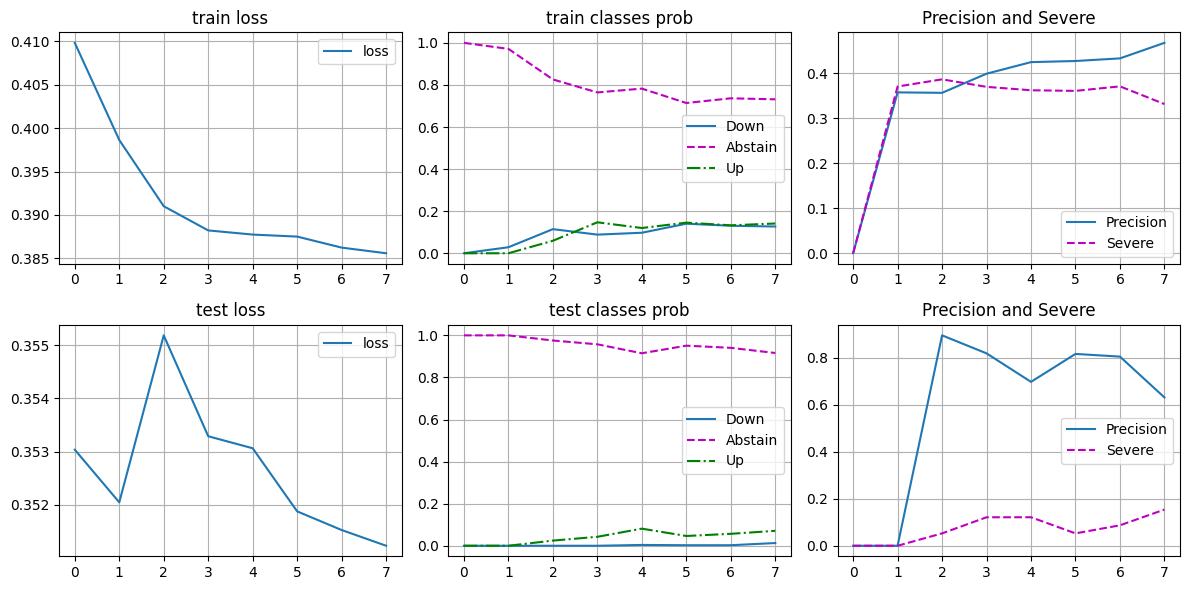

100%|██████████| 8/8 [00:00<00:00, 387.40it/s]


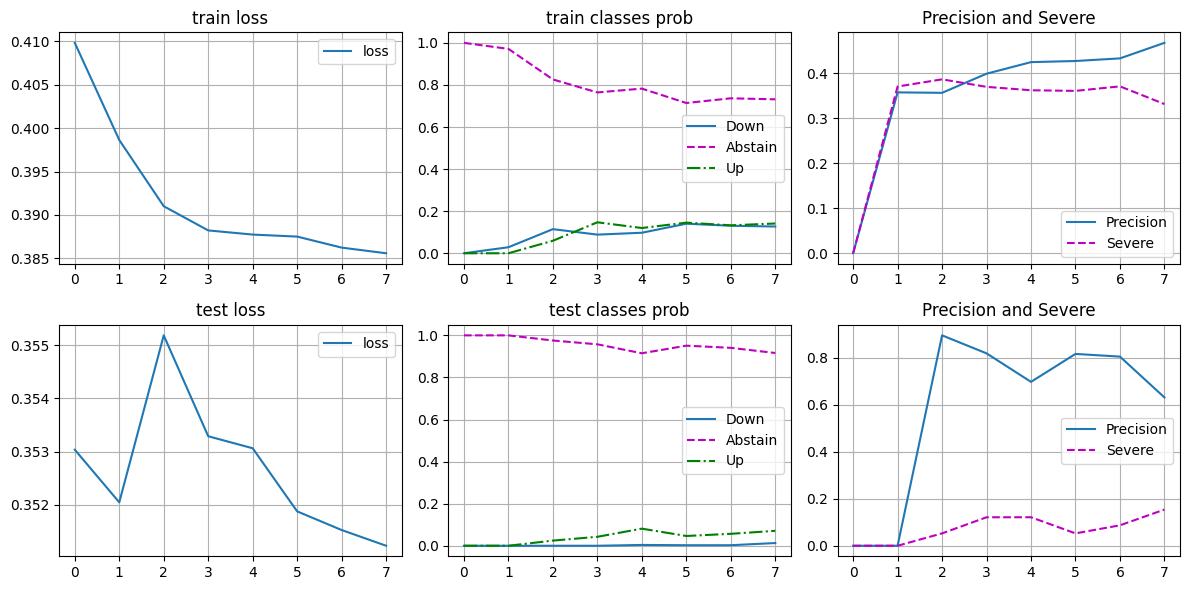

In [105]:
result = np.zeros(shape = (10, len(assets_list), 4))

for i in range(10):
    j = 0
    train_size = int(0.5*len(feature))
    validation_size = int(0.1*len(feature))
    test_size  = int(0.1*len(feature))

    split = np.random.randint(train_size, len(feature) - validation_size - test_size)

    train_set = TensorDataset(feature[:split], label[:split])
    balance_sampler = BalancedSampler(label[:split], 256)
    train_loader = DataLoader(train_set, batch_sampler=balance_sampler)

    validation_set = TensorDataset(feature[split:split+validation_size], label[split:split+validation_size])
    validation_loader = DataLoader(validation_set, batch_size=100)

    test_set = TensorDataset(feature[split+validation_size:split+validation_size+test_size], label[split+validation_size:split+validation_size+test_size])
    test_loader = DataLoader(test_set, batch_size=100)

    
    animator.reset()
    loss_fn = HybridLoss(alpha = 5e-2, delta = 1.3, show_loss = False)
    model = Baseline_LSTM(input_size = 10, hidden_size = 20, num_layers = 2, dropout = 0.3).to('cuda:0')
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay = 1e-3)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    train = ModelTrain(model = model,
                   train_loader = train_loader,
                   validation_loader = validation_loader,
                   test_loader = test_loader,
                   loss_fn = loss_fn,
                   optimizer = optimizer,
                   scheduler = scheduler,
                   recorder = recorder,
                   graph = animator,
                   )
    prediction, precision = train.epoch_train(epochs = 7, early_stop = 100)

    result[i,j,0] = prediction
    result[i,j,1] = precision

In [106]:
all_assets = pd.DataFrame({
    'stage_1_prediction': np.mean(result, axis = 0)[:,0],
    'stage_2_prediction': np.mean(result, axis = 0)[:,2],

    'stage_1_precision': np.mean(result, axis = 0)[:,1],
    'stage_2_precision': np.mean(result, axis = 0)[:,3],

    'stage_1_precision_std': np.std(result, axis = 0)[:,1],
    'stage_2_precision_std': np.std(result, axis = 0)[:,3],
})
all_assets.index = pd.Series(assets_list)
for col in all_assets.columns:
    all_assets[col] = all_assets[col].apply(lambda x: f"{x:.1%}")

# 转换为Markdown
markdown_table = all_assets.to_markdown(index=False)
print(f'hidden_size: {hidden_size}, num_layers: {num_layers}, seq_len: {seq_len}')
print(markdown_table)

hidden_size: 10, num_layers: 1, seq_len: 20
| stage_1_prediction   | stage_2_prediction   | stage_1_precision   | stage_2_precision   | stage_1_precision_std   | stage_2_precision_std   |
|:---------------------|:---------------------|:--------------------|:--------------------|:------------------------|:------------------------|
| 18.4%                | 0.0%                 | 15.9%               | 0.0%                | 22.2%                   | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |


hidden_size: 10, num_layers: 1, seq_len: 20
| stage_1_prediction   | stage_2_prediction   | stage_1_precision   | stage_2_precision   | stage_1_precision_std   | stage_2_precision_std   |
|:---------------------|:---------------------|:--------------------|:--------------------|:------------------------|:------------------------|
| 15.3%                | 0.0%                 | 19.0%               | 0.0%                | 12.3%                   | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |

hidden_size: 10, num_layers: 1, seq_len: 20
| stage_1_prediction   | stage_2_prediction   | stage_1_precision   | stage_2_precision   | stage_1_precision_std   | stage_2_precision_std   |
|:---------------------|:---------------------|:--------------------|:--------------------|:------------------------|:------------------------|
| 15.6%                | 0.0%                 | 25.2%               | 0.0%                | 16.7%                   | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |

hidden_size: 10, num_layers: 1, seq_len: 20
| stage_1_prediction   | stage_2_prediction   | stage_1_precision   | stage_2_precision   | stage_1_precision_std   | stage_2_precision_std   |
|:---------------------|:---------------------|:--------------------|:--------------------|:------------------------|:------------------------|
| 23.6%                | 0.0%                 | 11.0%               | 0.0%                | 9.9%                    | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |

hidden_size: 10, num_layers: 1, seq_len: 20
| stage_1_prediction   | stage_2_prediction   | stage_1_precision   | stage_2_precision   | stage_1_precision_std   | stage_2_precision_std   |
|:---------------------|:---------------------|:--------------------|:--------------------|:------------------------|:------------------------|
| 24.2%                | 0.0%                 | 10.0%               | 0.0%                | 13.7%                   | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |